In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

In [12]:
# LOAD THE DATA
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# PREPARE DATA FOR NEURAL NETWORK
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

# GLOBAL VARIABLES
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

## Experiment 1: Number of Convolution-Subsambling Pairs

In [13]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 3
model = [0] *nets

for j in range(3):
    model[j] = Sequential()
    model[j].add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
            input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    if j>0:
        model[j].add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
        model[j].add(MaxPool2D())
    if j>1:
        model[j].add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
        model[j].add(MaxPool2D(padding='same'))
    model[j].add(Flatten())
    model[j].add(Dense(256, activation='relu'))
    model[j].add(Dense(10, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size=0.333)

# TRAIN NETWORKS
history = [0] * nets
names = ["(C-P)x1", "(C-P)x2", "(C-P)x3"]
epochs = 20

for j in range(nets):
    history[j] = model[j].fit(
        X_train2, Y_train2,
        batch_size=80,
        epochs=epochs,
        validation_data=(X_val2, Y_val2),
        callbacks=[annealer],
        verbose=0
    )
    
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],
        epochs,
        max(history[j].history['accuracy']),
        max(history[j].history['val_accuracy'])
    ))


CNN (C-P)x1: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99099
CNN (C-P)x1: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99099


CNN (C-P)x2: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99035
CNN (C-P)x2: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99035


CNN (C-P)x3: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99171
CNN (C-P)x3: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99171


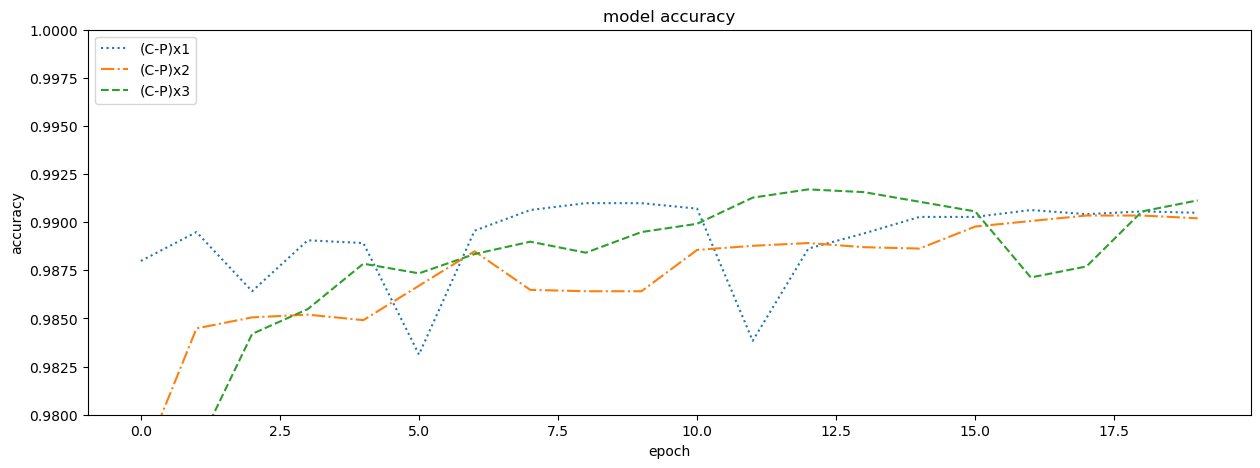

In [17]:
# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

### Summary
From the above experiment, it seems that 3 pairs of convolution-subsambling is slightly better than 2 pairs at some points but overall 2 is more cost efficent.

## Experiment 2: Number of Feature Maps

In [18]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 6
model = [0] *nets
for j in range(6):
    model[j] = Sequential()
    model[j].add(Conv2D(j*8+8,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    model[j].add(Conv2D(j*16+16,kernel_size=5,activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Flatten())
    model[j].add(Dense(256, activation='relu'))
    model[j].add(Dense(10, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.333)
# TRAIN NETWORKS
history = [0] * nets
names = ["8 maps","16 maps","24 maps","32 maps","48 maps","64 maps"]
epochs = 20
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs, 
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN 8 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99285
CNN 8 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99285


CNN 16 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99035
CNN 16 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99035


CNN 24 maps: Epochs=20, Train accuracy=0.99993, Validation accuracy=0.99056
CNN 24 maps: Epochs=20, Train accuracy=0.99993, Validation accuracy=0.99056


CNN 32 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99135
CNN 32 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99135


CNN 48 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99121
CNN 48 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99121


CNN 64 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99135
CNN 64 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99135


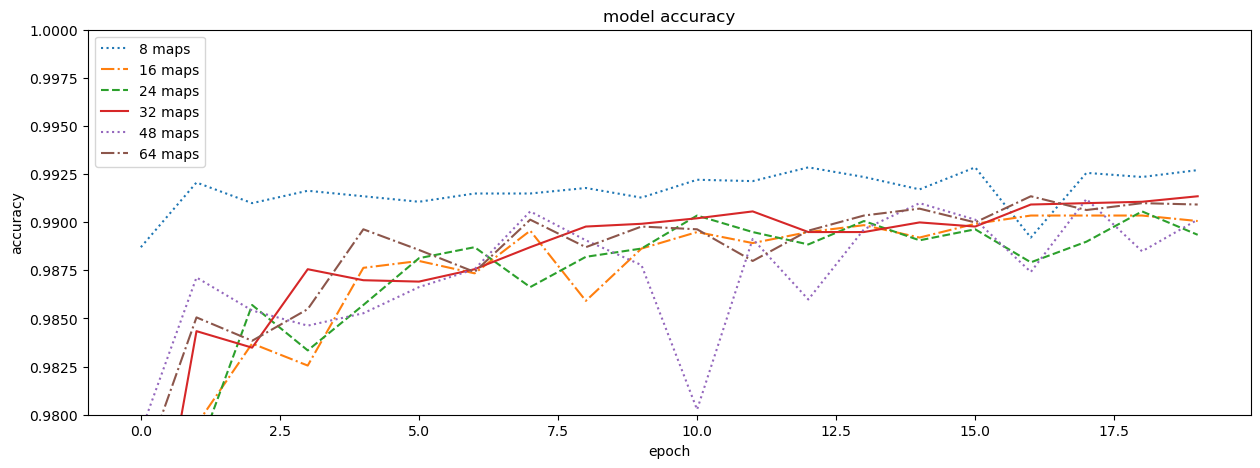

In [21]:
# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

### Summary
From the above experiement, it appears that 8 maps in the first convolutional layer and in the second convolutional layer is the best. 

## Experiment 3: Size of Dense Layer

In [ ]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 4
model = [0] *nets

for j in range(4):
    model[j] = Sequential()
    model[j].add(Conv2D(8,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    model[j].add(Conv2D(8,kernel_size=5,activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Flatten())
    if j>0:
        model[j].add(Dense(2**(j+4), activation='relu'))
    model[j].add(Dense(10, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [28]:
# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.333)
# TRAIN NETWORKS
history = [0] * nets
names = ["0N","32N","64N","128N"]
epochs = 10
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs, 
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN 0N: Epochs=10, Train accuracy=0.99964, Validation accuracy=0.99335
CNN 0N: Epochs=10, Train accuracy=0.99964, Validation accuracy=0.99335


CNN 32N: Epochs=10, Train accuracy=0.99950, Validation accuracy=0.99342
CNN 32N: Epochs=10, Train accuracy=0.99950, Validation accuracy=0.99342


CNN 64N: Epochs=10, Train accuracy=0.99946, Validation accuracy=0.99342
CNN 64N: Epochs=10, Train accuracy=0.99946, Validation accuracy=0.99342


CNN 128N: Epochs=10, Train accuracy=0.99925, Validation accuracy=0.99213
CNN 128N: Epochs=10, Train accuracy=0.99925, Validation accuracy=0.99213


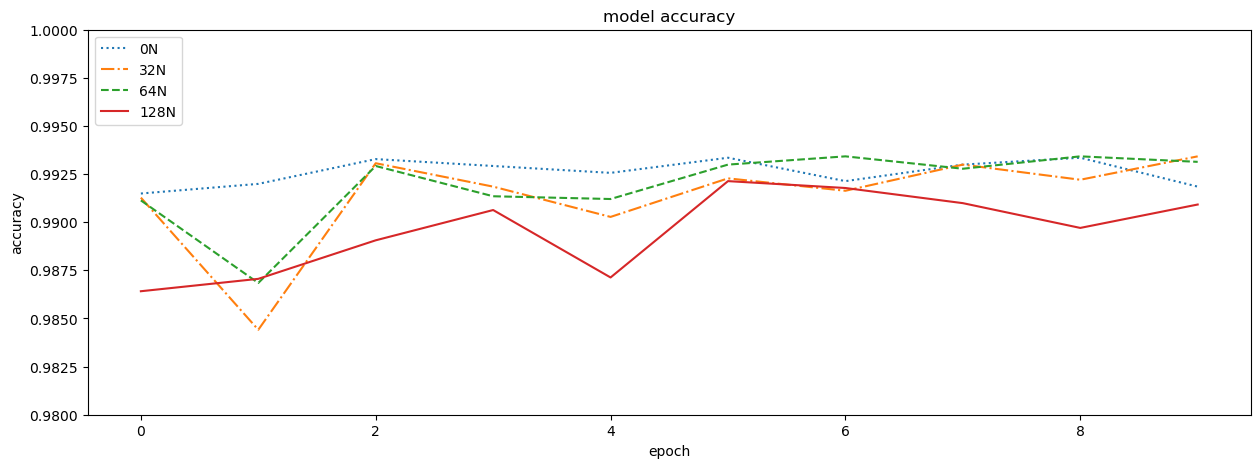

In [30]:
# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

### Summary 
I removed units larger than 128 and cut the number of epochs down to 10 because it was taking too long to run on my computer. Looking at the graph above, it appears that 32 units is the best.

## Experiment 4

In [31]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 8
model = [0] *nets

for j in range(8):
    model[j] = Sequential()
    model[j].add(Conv2D(8,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    model[j].add(Dropout(j*0.1))
    model[j].add(Conv2D(8,kernel_size=5,activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Dropout(j*0.1))
    model[j].add(Flatten())
    model[j].add(Dense(32, activation='relu'))
    model[j].add(Dropout(j*0.1))
    model[j].add(Dense(10, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.333)
# TRAIN NETWORKS
history = [0] * nets
names = ["D=0","D=0.1","D=0.2","D=0.3","D=0.4","D=0.5","D=0.6","D=0.7"]
epochs = 30
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs, 
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN D=0: Epochs=30, Train accuracy=0.99404, Validation accuracy=0.98155
CNN D=0: Epochs=30, Train accuracy=0.99404, Validation accuracy=0.98155


CNN D=0.1: Epochs=30, Train accuracy=0.98019, Validation accuracy=0.98520
CNN D=0.1: Epochs=30, Train accuracy=0.98019, Validation accuracy=0.98520


CNN D=0.2: Epochs=30, Train accuracy=0.96627, Validation accuracy=0.98270
CNN D=0.2: Epochs=30, Train accuracy=0.96627, Validation accuracy=0.98270


CNN D=0.3: Epochs=30, Train accuracy=0.94531, Validation accuracy=0.97869
CNN D=0.3: Epochs=30, Train accuracy=0.94531, Validation accuracy=0.97869


CNN D=0.4: Epochs=30, Train accuracy=0.91451, Validation accuracy=0.97419
CNN D=0.4: Epochs=30, Train accuracy=0.91451, Validation accuracy=0.97419


CNN D=0.5: Epochs=30, Train accuracy=0.85800, Validation accuracy=0.96439
CNN D=0.5: Epochs=30, Train accuracy=0.85800, Validation accuracy=0.96439


CNN D=0.6: Epochs=30, Train accuracy=0.76640, Validation accuracy=0.94852
CNN D=0.6: Epochs=30, Train accuracy=0.76640, Validation accuracy=0.94852


CNN D=0.7: Epochs=30, Train accuracy=0.64782, Validation accuracy=0.90061
CNN D=0.7: Epochs=30, Train accuracy=0.64782, Validation accuracy=0.90061


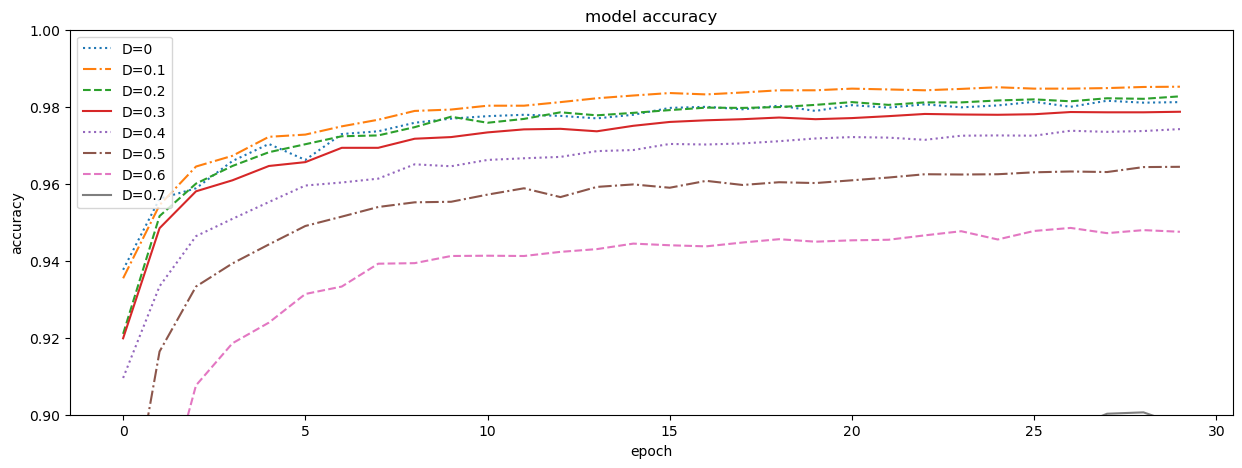

In [35]:
# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

### Summary
From this experiment, it appears that 10% dropout is the best.

In [36]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 5
model = [0] *nets

j=0
model[j] = Sequential()
model[j].add(Conv2D(8,kernel_size=5,activation='relu',input_shape=(28,28,1)))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.1))
model[j].add(Conv2D(8,kernel_size=5,activation='relu'))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.1))
model[j].add(Flatten())
model[j].add(Dense(32, activation='relu'))
model[j].add(Dropout(0.1))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

j=1
model[j] = Sequential()
model[j].add(Conv2D(8,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model[j].add(Conv2D(8,kernel_size=3,activation='relu'))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.1))
model[j].add(Conv2D(8,kernel_size=3,activation='relu'))
model[j].add(Conv2D(8,kernel_size=3,activation='relu'))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.1))
model[j].add(Flatten())
model[j].add(Dense(32, activation='relu'))
model[j].add(Dropout(0.1))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

j=2
model[j] = Sequential()
model[j].add(Conv2D(8,kernel_size=5,activation='relu',input_shape=(28,28,1)))
model[j].add(Conv2D(8,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(Dropout(0.1))
model[j].add(Conv2D(8,kernel_size=5,activation='relu'))
model[j].add(Conv2D(8,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(Dropout(0.1))
model[j].add(Flatten())
model[j].add(Dense(32, activation='relu'))
model[j].add(Dropout(0.1))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

j=3
model[j] = Sequential()
model[j].add(Conv2D(8,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model[j].add(BatchNormalization())
model[j].add(Conv2D(8,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(8,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.1))
model[j].add(Conv2D(8,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(8,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(8,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.1))
model[j].add(Flatten())
model[j].add(Dense(32, activation='relu'))
model[j].add(Dropout(0.1))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
j=4
model[j] = Sequential()

model[j].add(Conv2D(8,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model[j].add(BatchNormalization())
model[j].add(Conv2D(8,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(8,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.1))

model[j].add(Conv2D(8,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(8,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(8,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.1))

model[j].add(Flatten())
model[j].add(Dense(32, activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.1))
model[j].add(Dense(10, activation='softmax'))

model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.2)
# TRAIN NETWORKS 1,2,3,4
history = [0] * nets
names = ["basic","32C3-32C3","32C5S2","both+BN","both+BN+DA"]
epochs = 20
for j in range(nets-1):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=64, epochs = epochs,  
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))
    
# CREATE MORE TRAINING IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range=0.1,  
    width_shift_range=0.1, 
    height_shift_range=0.1
)

# TRAIN NETWORK 5 (with data augmentation)
j = nets - 1  # index for the 5th model
history[j] = model[j].fit(
    datagen.flow(X_train2, Y_train2, batch_size=64),
    epochs=epochs,
    steps_per_epoch=X_train2.shape[0] // 64,
    validation_data=(X_val2, Y_val2),
    callbacks=[annealer],
    verbose=0
)

# PRINT TRAINING SUMMARY
print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
    names[j],
    epochs,
    max(history[j].history['accuracy']),
    max(history[j].history['val_accuracy'])
))


CNN basic: Epochs=20, Train accuracy=0.98857, Validation accuracy=0.99250
CNN basic: Epochs=20, Train accuracy=0.98857, Validation accuracy=0.99250


CNN 32C3-32C3: Epochs=20, Train accuracy=0.98726, Validation accuracy=0.99190
CNN 32C3-32C3: Epochs=20, Train accuracy=0.98726, Validation accuracy=0.99190


CNN 32C5S2: Epochs=20, Train accuracy=0.99167, Validation accuracy=0.99226
CNN 32C5S2: Epochs=20, Train accuracy=0.99167, Validation accuracy=0.99226


CNN both+BN: Epochs=20, Train accuracy=0.99485, Validation accuracy=0.99452
CNN both+BN: Epochs=20, Train accuracy=0.99485, Validation accuracy=0.99452


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


CNN both+BN+DA: Epochs=20, Train accuracy=0.97711, Validation accuracy=0.99071
CNN both+BN+DA: Epochs=20, Train accuracy=0.97711, Validation accuracy=0.99071


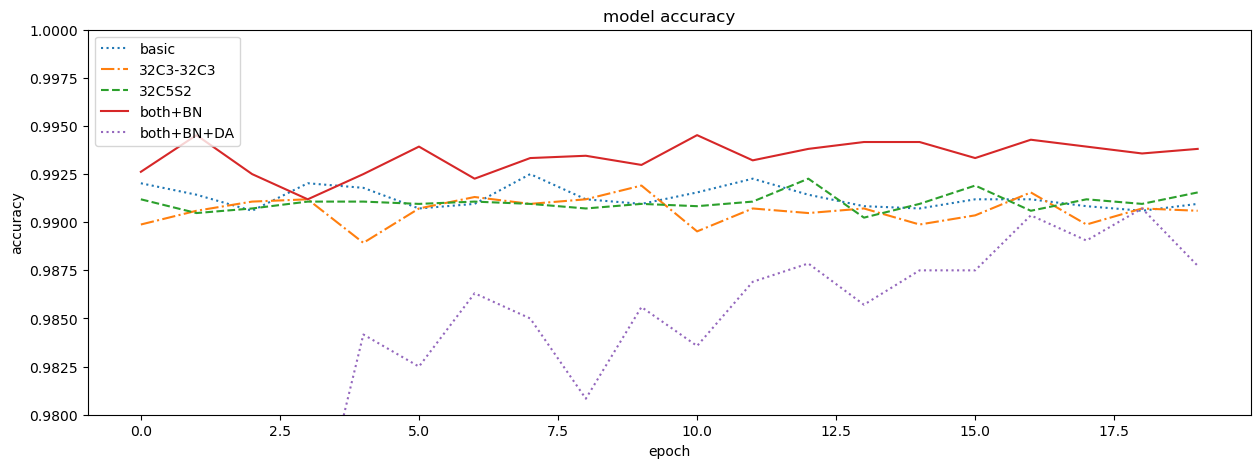

In [42]:
# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

### Summary
The first model uses no advanced features. The second uses only the double convolution layer trick. The third uses only the learnable subsambling layer trick. The third model uses both of those techniques plus batch normalization. The last model employs all three of those techniques plus data augmentation.
From this experiment, we see that the third model has the best accuracy of 99.5%. 

